# Benchmark: PXD024043 - Proteins

This notebook contains code to benchmark the model on the [PXD024043 dataset](https://www.ebi.ac.uk/pride/archive/projects/PXD024043) - cell cycle proteomes. 
Four cell populations enriched in different cell cycle stages were produced from HeLa cells by drug treatment.
Here, we'll use the protein dataset. Download the zip-file, "DIANN1.8_SingleCells_CellCycle.zip" and locate the file, "20210919_DIANN_SingleCellOutput.pg_matrix.tsv".

Let's start with the imports.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm
import scp.simulations as sm
import scp.metrics as metrics

import scvi

np.random.seed(42)
scvi.settings.seed = 42

Global seed set to 42


In [2]:
adata = sc.read("../../../data/processed/brunner2022.h5ad")

In [93]:
m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.08, mnar_proportion=1, x=adata.layers["raw"], seed=42)

In [94]:
print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

MNAR: 0.026, MCAR: 0.000


In [95]:
train_mask = ~(m_mcar | m_mnar)

sm.add_train_test_set(adata, train_mask, layer="raw")

## PROTVI

### Training

Let's now train the model.

In [116]:
adata.X = adata.layers["train"].copy()
adata.X[np.isnan(adata.X)] = 0

In [117]:
PROTVI.setup_anndata(adata) #, batch_key="coarse_condition")

model = PROTVI(adata, log_variational=False,  n_hidden=32, decoder_type="selection")
#model.view_anndata_setup()

Let's train the model.

In [118]:
model.train(max_epochs=4000, plan_kwargs={"mechanism_weight": 0.1, "lr": 2e-3}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 6, "max_kl_weight": 6})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 4000/4000: 100%|██████████| 4000/4000 [08:45<00:00,  9.19it/s, v_num=1, train_loss_step=986, train_loss_epoch=967]        

`Trainer.fit` stopped: `max_epochs=4000` reached.


Epoch 4000/4000: 100%|██████████| 4000/4000 [08:45<00:00,  7.61it/s, v_num=1, train_loss_step=986, train_loss_epoch=967]


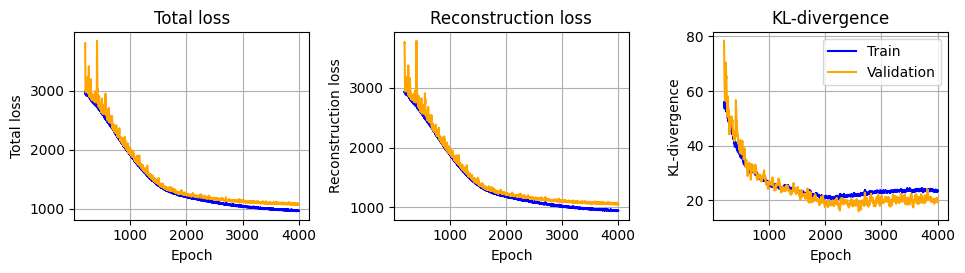

In [119]:
pl.plot_loss(model.history, epoch_start=200)

### Evaluation on training set

In [239]:
x_est, p_est = model.impute(n_samples=100, loss_type="iwae")

In [240]:
x_test = adata.layers["test"]

x_guess = x_est.copy()
x_guess[np.isnan(x_test)] = np.nan

x_true = x_test.copy()

In [250]:
mse_test = metrics.mse(x_guess[~np.isnan(x_test)], x_true[~np.isnan(x_test)])
print(f"Test MSE: {mse_test:.4f}")

Test MSE: 0.5160


Text(0.5, 1.0, 'Imputation accuracy (MSE: 0.5160)')

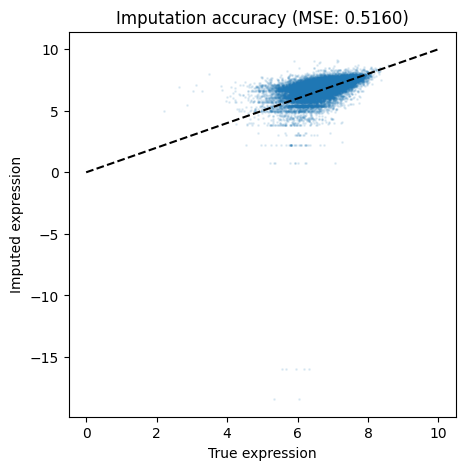

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot([0, 10], [0, 10], ls="--", c="black")
ax.scatter(x_true, x_guess, s=1, alpha=0.1)
ax.set_xlabel("True expression")
ax.set_ylabel("Imputed expression")
ax.set_title(f"Imputation accuracy (MSE: {mse_test:.4f})")

In [ ]:
adata.layers["knn"] = bm.impute_knn(adata, layer="train")
x_min = np.nanmin(adata.layers["train"])
adata.layers["knn"][np.isnan(adata.layers["knn"])] = x_min
x_ref = adata.layers["knn"][~np.isnan(x_test)].copy()
x_guess = x_est[~np.isnan(x_test)].copy()

print(np.sum(x_guess < x_min) / x_guess.size)

x_guess[x_guess < x_min] = x_ref[x_guess < x_min]
mse_test = metrics.mse(x_guess, x_true)

print(f"Test MSE: {mse_test:.4f}")